# The Problem

Consider a batch chemical reactor, hosting a simple reaction.

$A \rightarrow \nu B$

A system of Ordinary Differential Equations (ODE) is proposed to model the system. To develop it, experiments will be run to estimate the values of the unknown model parameters: the order of reaction $\alpha$, the stoichiometric ratio $\nu$, the transformed pre-exponential constant $\theta_0$, and transformed activation energy $\theta_1$.

**The Model**

$\frac{dc_A}{dt} = -r$

$\frac{dc_B}{dt} = \nu r$

$r = kc_A^\alpha$

$k = \exp \left(\theta_0 + \theta_1 \left(\frac{T-T_{ref}}{T}\right)\right)$

Due to a stringent time constraint, the experimenter must conduct ten (10) number of experiments in parallel to best estimate these model parameters. The experimental variables are sampling times $t \in [0, 200]$ in minutes, initial A concentration $c_A^0 \in [1, 5]$ in mol/L, and reaction temperature $T\in [273.15, 323.15]$ K. The initial concentration of B is assumed to be zero, as it is the desired product. The experimental setup supports spectroscopic measurements, allowing repeated measurements every 20 minutes. As a result, all dynamic experiments are to be 200 minutes in duration, with the same sampling time choices. Additionally, initial experimental data and a-priori knowledge on the system provides an initial nominal parameter estimate of $[-4.5, 2.2, 1.0, 0.5]$. Use principles of model-based experiment design to derive a continuous experimental design, suitable for constructing the ten experiments to be conducted in parallel. Obtain a D-optimal continuous experimental design for the estimation of the model's parameter values.

# Preparing the Python Environment

First things first, we ensure that all required dependencies are installed.

In [1]:
!pip install pydex==0.0.7
!pip install numdifftools==0.9.39
!pip install pyomo==5.7
!pip install casadi==3.4.5
!pip install cvxpy==1.0.25
!pip install scipy==1.5.3
!pip install matplotlib==3.1.3
!pip install dill==0.3.4
!pip install numpy==1.19.4
!pip install scs==2.1.2

  Using cached https://files.pythonhosted.org/packages/b6/c3/973676ceb86b60835bb3978c6db67a5dc06be6cfdbd14ef0f5a13e3fc9fd/dill-0.3.4-py2.py3-none-any.whl
  Found existing installation: dill 0.3.3
    Uninstalling dill-0.3.3:
      Successfully uninstalled dill-0.3.3


We then import the packages, and modules we need for solving an experimental design problem.

In [2]:
from pydex.core.designer import Designer
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from pyomo import environ as po
from pyomo import dae as pod
import numpy as np

To ensure the ipython notebook works in google collab as well, we set matplotlib to be show inline figures.

In [3]:
%matplotlib inline

# Creating the ODE Model

We start by defining the ODE within the Pyomo and Pyomo.DAE environment; please refer to official documentation for [Pyomo](https://pyomo.readthedocs.io/en/stable/index.html) and [Pyomo.DAE](https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html) for help in this section.

In [4]:
def create_model(spt):
  model = po.ConcreteModel()
  model.t = pod.ContinuousSet(bounds=(0, 1), initialize=spt)
  model.tau = po.Var()

  model.temp = po.Var()

  # state variables
  model.ca = po.Var(model.t, bounds=(0, 50))
  model.cb = po.Var(model.t, bounds=(0, 50))
  model.dca_dt = pod.DerivativeVar(model.ca, wrt=model.t)
  model.dcb_dt = pod.DerivativeVar(model.cb, wrt=model.t)

  # model parameters
  model.theta_0 = po.Var() 
  model.theta_1 = po.Var()
  model.alpha_a = po.Var()
  model.alpha_b = po.Var()
  model.nu = po.Var()

  def _material_balance_a(m, t):
    k = po.exp(m.theta_0 + m.theta_1 * (m.temp - 273.15) / m.temp)
    return m.dca_dt[t] / m.tau == - k * (m.ca[t] ** model.alpha_a) * (model.cb[t] ** model.alpha_b)
  model.material_balance_a = po.Constraint(model.t, rule=_material_balance_a)

  def _material_balance_b(m, t):
    k = po.exp(m.theta_0 + m.theta_1 * (m.temp - 273.15) / m.temp)
    return m.dcb_dt[t] / m.tau == m.nu * k * (m.ca[t] ** model.alpha_a) * (model.cb[t] ** model.alpha_b)
  model.material_balance_b = po.Constraint(model.t, rule=_material_balance_b)

  simulator = pod.Simulator(model, package='casadi')

  return model, simulator


# Create the Simulate Function

Next, we need to define a simulate function with a specific signature to follow Pydex's requirement. In our example, we only have time-invariant controls, or tics for short. But, since our example is dynamic, sampling_times is one of the input arguments to our simulate function. The simulate function can be named anything, and does not have to be named "simulate". However, the input arguments must be named "ti_controls", "sampling_times", and "model_parameters". Moreover, the order in which they appear are also important.

In [5]:
def simulate(ti_controls, sampling_times, model_parameters):
    """ ensuring pyomo returns state values at given sampling times """
    # model needs to be re_constructed from scratch
    model, simulator = create_model(sampling_times)

    """ fixing the model parameters """
    model.theta_0.fix(model_parameters[0])
    model.theta_1.fix(model_parameters[1])
    model.alpha_a.fix(model_parameters[2])
    model.alpha_b.fix(0)
    model.nu.fix(model_parameters[3])

    """ fixing the control variables """
    model.tau.fix(200)
    model.ca[0].fix(ti_controls[0])
    model.cb[0].fix(0)
    model.temp.fix(ti_controls[1])

    """ simulating """
    simulator.simulate(integrator='idas')
    simulator.initialize_model()

    """" extracting results and returning it in appropriate format """
    ca = np.array([model.ca[t].value for t in model.t])
    cb = np.array([model.cb[t].value for t in model.t])

    return np.array([ca, cb]).T


The inputs "ti_controls", "sampling_times", and "model_parameters" will be in the form of a one-dimensional numpy array. The first two represent the values of the differenc tics, and sampling_times we will have for the system for **one** given experimental candidate. Whilst "model_parameters" represent the values of the different model parameters for a **single** uncertainty scenario. In this example, we will only visit local designs, where only a single uncertainty scenario is considered, but Pydex supports other optimal experimental design techniques that uses multiple parameter scenarios too.

The simulate function must return a two-dimensional numpy array, containing values of the measured responses at different sampling times. The first dimension is sampling times, and the second is the different responses. Non-dynamic systems are treated as dynamic systems with one sampling time. Similarly, uniresponse systems are treated as multiresponse systems with one response.

**Test Simulation**

We now test/illustrate our simulate function and present the simulation results done via our simulate function with matplotlib.

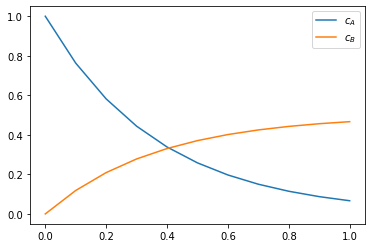

In [6]:
spt = np.linspace(0, 1, 11)
y = simulate(
  ti_controls=[1, 300.15],
  sampling_times=spt,
  model_parameters=[-4.5, 2.2, 1.0, 0.5],
)
fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(
  spt,
  y[:, 0],
  label="$c_A$",
)
axes.plot(
    spt,
    y[:, 1],
    label="$c_B$",
)
axes.legend()
plt.show()

# [Optional reading]: ordering of inputs for simulate functions
To better understand how to specify simulate functions, they are based on a ranking system. Each input argument has a ranking. Higher ranked inputs appear ahead of those lower in rank. The most complete signature for the simulate function is:

    simulate(ti_controls, tv_controls, sampling_times, model_parameters)

Meaning, ranking of the inputs in descending order are ti_controls, tv_controls, sampling_times, model_parameters. Model parameters will always be present and always come last. The rest can be absent, depending on the system, but for those present, must appear in order of their ranks.

# Solving Experimental Designs via Pydex

All activities using Pydex are done through Pydex's designer object. The main steps are to create a pydex.designer instance, pass in the simulate function we just defined above, and pass in the various components required to design an experiment.

In [7]:
designer_1 = Designer()
designer_1.simulate = simulate

In this case, given the initial set of information we are given, we can only design the so-called locally optimal design, which means we need to define the nominal model parameter value.

In [8]:
theta_nom = [-4.5, 2.2, 1.0, 0.5]  # value of beta, a 1D np.array
designer_1.model_parameters = theta_nom  # pass it to the designer

**Enumerating Time-invariant Controls**

Additionally, we need to define the time-invariant control candidates for all candidates that we will compute our optimal experiment design from. For this simple example, we will enumerate the candidates from a simple mesh-centered grid. Pydex provides an easy interface to do this. Our tics for this case are initial concentration of A, and reaction temperature. And don't forget to pass it to the designer.

In [9]:
tic = designer_1.enumerate_candidates(
  bounds=[
    [1, 5],             # initial C_A concentration
    [273.15, 323.15]    # reaction temperature
  ],
  levels=[
    5,                 # initial C_A concentration
    5,                 # reaction temperature
  ],
)
designer_1.ti_controls_candidates = tic

The candidate enumeration interface requires us to specify two arguments, bounds, and levels. Bounds determines the boundaries of the grid that we will be enumerating the tics from. Levels specifies the resolution of the mesh-centered grid. The syntax above implies a total of twenty-five (5x5) number of candidates.

In [10]:
print(np.array2string(tic, separator=", "))

[[  1.  , 273.15],
 [  1.  , 285.65],
 [  1.  , 298.15],
 [  1.  , 310.65],
 [  1.  , 323.15],
 [  2.  , 273.15],
 [  2.  , 285.65],
 [  2.  , 298.15],
 [  2.  , 310.65],
 [  2.  , 323.15],
 [  3.  , 273.15],
 [  3.  , 285.65],
 [  3.  , 298.15],
 [  3.  , 310.65],
 [  3.  , 323.15],
 [  4.  , 273.15],
 [  4.  , 285.65],
 [  4.  , 298.15],
 [  4.  , 310.65],
 [  4.  , 323.15],
 [  5.  , 273.15],
 [  5.  , 285.65],
 [  5.  , 298.15],
 [  5.  , 310.65],
 [  5.  , 323.15]]


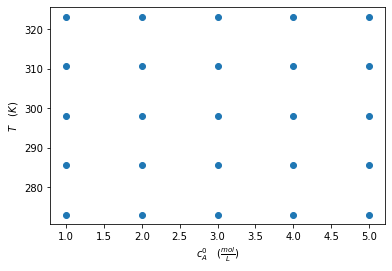

In [11]:
plt.scatter(
  tic[:, 0],
  tic[:, 1],
)
plt.xlabel(r"$c_A^0 \quad (\frac{mol}{L})$")
plt.ylabel("$T \quad (K)$")
plt.show()

**Specifying Sampling Times**

After passing in the tics, because we have a dynamic system, and we are designing dynamic experiments, we still need to define the spts (sampling time candidates). These specifies all possible times that measurements of the system's responses can be taken. Note that this also indirectly defines the batch times for the experiments! Pydex supports experiments with varying batch times, and varying number of sampling times. But, for this example, we assume that all experiments will have the same sampling time choices.

In [12]:
spt = np.array([
  np.linspace(0, 1, 11)
  for _ in tic
])
designer_1.sampling_times_candidates = spt

In [13]:
print(np.array2string(spt, separator=", "))

[[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
 [0. , 0.1, 0.

**Initialization**

We have just completely specified all the required components for designing an experiment. Before proceeding to do any activity with pydex, it is crucial to initialize the designer. Initialization will allow Pydex to check for any syntax errors that may be made up to this point. Pydex also determines the problem sizes, types, and estimate the memory requirement. Pydex will warn the user should the problem require a large memory requirement. Initialization is the preferred way of specifying Pydex's verbosity. Verbosity is represented as a positive real number. A verbosity less than or equal to 0 (zero) means that pydex will be silent. A verbosity greather than one or equal to 1 (one) means that pydex reports its progress outline. A verbosity greater than or equal to 2 (two) means that pydex report the detail of its progress. To showcase what pydex can report, we will opt for detailed verbosity. In some rare cases, mostly for identifying bugs, a verbosity of greater than or equal to 3 can be useful, where progress on some very low-level operations are reported as well.

In [14]:
verbosity = 2 #@param {type:"slider", min:0, max:3, step:0.1}
designer_1.initialize(verbose=verbosity)

Initialization complete: designer ready.
----------------------------------------------------------------------------------------------------
Number of model parameters              : 4
Number of candidates                    : 25
Number of responses                     : 2
Number of measured responses            : 2
Number of time-invariant controls       : 2
Number of sampling time choices         : 11


'ready'

Pydex also offers some automated visualization features. To customize these visualizations, we can identify experimental candidates, tics, responses, and model parameters by giving them names. These are done by passing in lists/arrays into the appropriate attribute to Pydex's designer, as below.

In [15]:
"""
=====================================================================================
[Optional]
1. Specify measurable states:
    A 1D array containing a subset of column numbers specifying the measurable states 
    from the response array returned by the simulate function. If un-specified, all 
    responses are assumed measurable.
2. Name candidates, responses, and model parameters for plotting purposes.
    Adds titles to individual subplots whenever applicable.
3. Save state.
    Saves the experimental candidates, nominal model parameter values to be loaded 
    for running related scripts in the future. State is saved into a pickle file.
=====================================================================================
"""
designer_1.measurable_responses = [0, 1]

designer_1.candidate_names = np.array([
  f"Candidate {i+1}"
  for i, _ in enumerate(tic)
])
designer_1.response_names = ["c_A", "c_B"]
designer_1.model_parameter_names = [
  r"\theta_0",
  r"\theta_1",
  r"\alpha",
  r"\nu",
]

**Supported Solvers**

We now need to solve the experimental design optimization problem. We recommend using the optimizer MOSEK through the package CVXPY, if you have a license to MOSEK. Otherwise, we suggest using the optimizer SCS through CVXPY. Although CVXPY supports many other optimizers, for D-optimal designs, only SCS and MOSEK are supported. For a full list of optimizers available through CVXPY, see their [official documentation](https://www.cvxpy.org/tutorial/advanced/index.html#solve-method-options).

An important note in using SCS is that the default optimizer settings will often lead to premature termination of the optimization procedure as the "max_iter" settings lead to a rather small number of maximum iterations for experimental design problems. For instance, to pass this option on, we should include the keyword argument max_iters=100000 to the design_experiment method.

Pydex also interfaces with all optimizers supported via scipy.optimize.minimize that does not require a Jacobian function. The full list can be found in their [official documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

**Solver Options**

Here, we use the open-source SLSQP solver through scipy. Should you want to pass in solver parameters, scipy solvers will take in keyword arguments through a dictionary of solver options, passed in to pydex.design_experiment method as the keyword argument "options". Of course, different solvers will have different keyword arguments. In contrast, CVXPY solvers will take in solver options directly as keyword arguments of the designer.design_experiment method. See [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html#solve-method-options) documentation for more details.

In [16]:
package = "scipy" #@param ["scipy", "cvxpy"]
optimizer = "SLSQP" #@param ["SCS", "SLSQP", "l-bfgs-b", "bfgs", "nelder-mead", "TNC", "COBYLA", "MOSEK"]

""" solve OED problem """
criterion = designer_1.d_opt_criterion
scipy_result = designer_1.design_experiment(
    criterion=criterion,
    package=package,
    optimizer=optimizer,
    optimize_sampling_times=True,
    write=False,
)

############################### Computing Optimal Experiment Design ################################
Started on                              : 2021-06-30 11:55:02.640730
Criterion                               : d_opt_criterion
Pseudo-bayesian                         : False
Dynamic                                 : True
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 25
Number of Sampling Time Choices         : 11
Sampling Times Optimized                : True
---------------------------------------[Sensitivity Analysis]---------------------------------------
Richardson Extrapolation Steps          : 5
----------------------------------------------------------------------------------------------------
[Candidate       3/25]: time elapsed            0.50 seconds.
[Candidate       6/25]: time elapsed            0.96 seconds.
[Candidate       9/25]: time elapsed            1.43 seconds.
[Candidate   

**Retrieving the optimal experimental recipe**

To retrieve the obtained solution, the main method to invoke is print_optimal_candidates. This prints out the problem types, sizes, and other details. Following these are the optimal candidates, along with the optimal efforts, percentages of experiments, to run. 

In [17]:
designer_1.print_optimal_candidates()


######################################## Optimal Candidates ########################################
Obtained on                             : 2021-06-30 11:55:13.803856
Criterion                               : d_opt_criterion
Criterion Value                         : -1.4972569417134867
Pseudo-bayesian                         : False
CVaR Problem                            : False
Dynamic                                 : True
Time-invariant Controls                 : True
Time-varying Controls                   : False
Number of Candidates                    : 25
Number of Optimal Candidates            : 2
Number of Sampling Time Choices         : 11
Sampling Times Optimized                : True
Number of Samples Per Experiment        : 1
Information Matrix Regularized          : False
Minimum Effort Threshold                : 0.0001
-------------------------------------------[Candidate 21]-------------------------------------------
                             Recommended Effort:

**Using the Results**

For our problem, the recipe (roughly) translates to running 2 repetitions of Candidate 6, 3 repetitions of Candidate 21, and 5 repetitions of Candidate 25.

**Important Caveat**

Although a good solution, these are likely to be sub-optimal solutions. To obtain the true optimal, one must solve the so-called exact experimental design problem, and consider the fully continuous experimental spaces instead of relying on candidate enumeration as we did here; a problem we are not going to focus on. But, for many purposes, such designs, obtained from discretized experimental spaces, and derived from rounding of non-integer experimental efforts would provide a significant improvement to experiments designed heuristically.

**Visualization of Optimal Efforts**

An alternative to printing the optimal candidates, Pydex also offers a bar chart visualization of the same information. This is invoked through plot_optimal_efforts.

Plotting current continuous design.


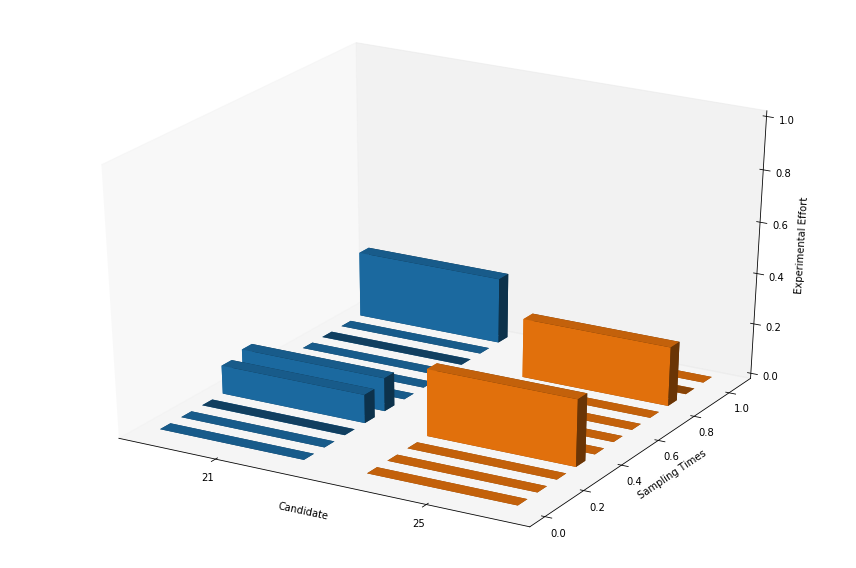

In [18]:
designer_1.plot_optimal_efforts(write=False)
designer_1.show_plots()

**Predicted System Response**

After experimental design, it is often a good idea to obtain predicted system responses to each of the optimal experiments that would be run to ensure that no safety, feasibility, or any other concern could arise from the experiments.

The main method to invoke is plot_optimal_predictions, available only for dynamic systems. This plots the trajectory of all responses in all optimal candidates over time. Trajectories of different responses are presented in different subplotsl; whilst different optimal candidates are presented in the same subplot, differentiated using different colors.

The markers on the plots represent the sampling time for the chosen optimal candidate. This experimental design was obtained without optimizing sampling times, and these are shown simply as eleven (11) equally-spaced points over the whole range of sampling times.

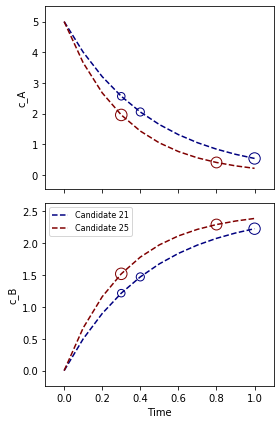

In [19]:
designer_1.plot_optimal_predictions()
designer_1.show_plots()

**Analyzing Experimental Information via Sensitivities Plots**

To assess how effective informative each optimal experiment is for estimating the model parameter values, it is customary to plot the sensitivity profiles of the system responses with respect to the parameter values. This can easily be done by invoking the plot_optimal_sensitivities method. By default, it will present an interactive matplotlib plot, to support larger problems with large number of responses and/or model parameters. However, for documentation purposes, we will pass in interactive=False.

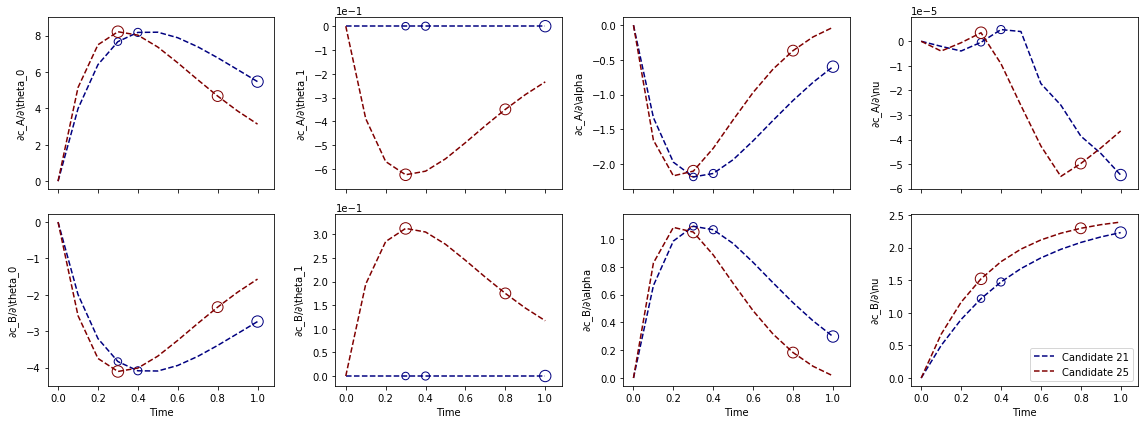

In [20]:
designer_1.plot_optimal_sensitivities(interactive=False)
designer_1.show_plots()

The subplots are arranged in rows, and columns according to the number of responses (2), and number of model parameters, respectively. The x-axis of all subplots refer to the sampling times, whilst the y-axis are the sensitivities themselves. The top-left plot visualizes the sensitivity of the first response ($c_A$) with respect to the first model parameter $\theta_0$ over time. It tells us that in all optimal experimental candidates, as the value of $\theta_0$ increases, the values of $c_A$ at various times will decrease. There is a peak time in which the effect of $\theta_0$ on $c_A$ is at its maximum. Similar analysis can be applied to the rest of the subplots to better understand the system.

**Some Interesting Points**

In general, the higher the magnitude of the sensitivities, the more informative the experiments are. An important thing to note here is the top-right subplot. The magnitude of the sensitivities can be wildly different. And these are presented using matplotlib's scientific notation to show order of magnitude. The "1e-6" means that these sensitivities are essentially zero, and the fluctuations over time that is visualized there are due to numerical error of the estimation of the sensitivities.

Another interesting point is that in the plots of the second column, profiles for candidate 21 and candidate 6 overlap with each other, and are always zero, as compared to candidate 25. This is unique to the specific system we are investigating, because candidate 6 and 21 have reaction temperatures equal to the reference temperature. This causes a numerical property that the sensitivities are always zero.